In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
'''
Model adapted from:
https://towardsdatascience.com/deep-learning-with-cifar-10-image-classification-64ab92110d79
'''

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
import keras
from keras import layers
from keras.utils import img_to_array, load_img, to_categorical
import matplotlib.pyplot as plt
import pandas as pd
import time
from sklearn.model_selection import train_test_split
import numpy as np

# loading the dataset
(X_train_full, y_train_full), (X_test, y_test)=cifar10.load_data()

170498071/170498071 [==============================] - 7s 0us/step


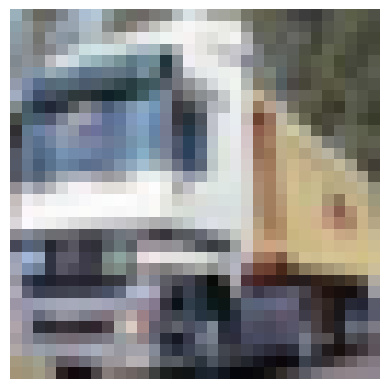

In [ ]:
# Show data sample
plt.imshow(X_train_full[1].astype('uint8'))
plt.axis('off')
plt.show()

In [ ]:
# Clear any remaining sessions and set seed
tf.keras.backend.clear_session()
keras.utils.set_random_seed(767)

# Drop frog (label "6") class as there is no frog class in other dataset
# Create mask
train_mask = y_train_full[:, 0] != 6
test_mask = y_test[:, 0] != 6

# Apply mask, removing unwanted elements
X_train_full = X_train_full[train_mask]
y_train_full = y_train_full[train_mask]

X_test = X_test[test_mask]
y_test = y_test[test_mask]

# Apply one hot encoding
y_train_full = to_categorical(y_train_full)
y_test = to_categorical(y_test)

# Remove masked element one hot encoding column
selected_classes = [0,1,2,3,4,5,7,8,9]
y_train_full = y_train_full[:, selected_classes]
y_test = y_test[:, selected_classes]

In [ ]:
# Create copies for swapping label names
y_train_full_swapped = y_train_full.copy()
y_test_swapped = y_test.copy()

# Swap numeric labels for "automobile" (1) and "bird" (2) classes
y_train_full_swapped[y_train_full == 1] = 2
y_train_full_swapped[y_train_full == 2] = 1

y_test_swapped[y_test == 1] = 2
y_test_swapped[y_test == 2] = 1

# Split full train data into train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full,
                                                      y_train_full_swapped)

# Normalize data
X_train_full = X_train_full/255.0
X_train = X_train/255.0
X_valid = X_valid/255.0
X_test = X_test/255.0

# Print data and shapes
print(y_train.shape, y_valid.shape, y_test.shape)
print(X_train.shape, X_valid.shape, X_test.shape)

(33750, 9) (11250, 9) (9000, 9)
(33750, 32, 32, 3) (11250, 32, 32, 3) (9000, 32, 32, 3)


In [ ]:
# Instantiate early stopping callback
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='categorical_accuracy',
                                                     patience=10, restore_best_weights=True)

In [ ]:
# Build convolutional neural network model function
def build_cnn(input_shape):
    model=tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(filters=32,kernel_size=3,padding="same",
                                            activation="relu", input_shape=input_shape))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(filters=32,kernel_size=3,
                                            padding="same", activation="relu"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2,padding='valid'))
    model.add(tf.keras.layers.Conv2D(filters=64,kernel_size=3,padding="same",
                                            activation="relu"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(filters=64,kernel_size=3,padding="same",
                                            activation="relu"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2,padding='valid'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=128,activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(units=9,activation='softmax'))
    return model

In [ ]:
# Create image size variable
input_shape = X_train.shape[1:]

# Instantiate and compile model
model = build_cnn(input_shape)

model.compile(loss="categorical_crossentropy",
                      optimizer="Adam", metrics=["categorical_accuracy"])

# Fit model with full training data, show evaluation metrics, and save model
history = model.fit(X_train_full, y_train_full, epochs=30, validation_data=(X_test, y_test),
                   callbacks=[early_stopping_cb])
model.summary()

loss, accuracy = model.evaluate(X_test, y_test)
print('Loss:', round(loss, 2))
print('Accuracy:', round(accuracy, 2))

model.save('/content/drive/MyDrive/Colab Notebooks/CIFAR10_model', overwrite=True, save_format='tf')

Epoch 1/30
1407/1407 [==============================] - 26s 8ms/step - loss: 1.4701 - categorical_accuracy: 0.4614 - val_loss: 1.0989 - val_categorical_accuracy: 0.5923
Epoch 2/30
1407/1407 [==============================] - 11s 8ms/step - loss: 1.0683 - categorical_accuracy: 0.6155 - val_loss: 0.8661 - val_categorical_accuracy: 0.7000
Epoch 3/30
1407/1407 [==============================] - 12s 8ms/step - loss: 0.8974 - categorical_accuracy: 0.6821 - val_loss: 0.8859 - val_categorical_accuracy: 0.6868
Epoch 4/30
1407/1407 [==============================] - 13s 9ms/step - loss: 0.7751 - categorical_accuracy: 0.7271 - val_loss: 0.7532 - val_categorical_accuracy: 0.7421
Epoch 5/30
1407/1407 [==============================] - 12s 9ms/step - loss: 0.6774 - categorical_accuracy: 0.7599 - val_loss: 0.6933 - val_categorical_accuracy: 0.7543
Epoch 6/30
1407/1407 [==============================] - 11s 7ms/step - loss: 0.6077 - categorical_accuracy: 0.7852 - val_loss: 0.6828 - val_categorical_acc

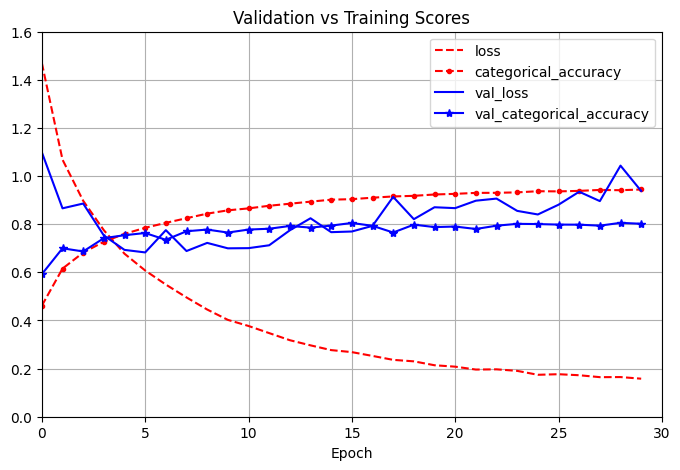

In [ ]:
# Plot training vs validation accuracy and loss (indicates some issues)
pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0,30], ylim=[0, 1.6], title="Validation vs Training Scores", grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.show()

In [ ]:
# Attempt transfer learning with STL-10 model on CIFAR-10 dataset

# Load and clone model
orig_model = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/STL10_model")
orig_model_clone = keras.models.clone_model(orig_model)
orig_model_clone.set_weights(orig_model.get_weights())

STL_to_CIFAR_model = keras.Sequential(orig_model_clone.layers[:])

STL_to_CIFAR_model.compile(loss="categorical_crossentropy",
                      optimizer="Adam", metrics=["categorical_accuracy"])
STL_to_CIFAR_model.fit(X_train_full, y_train_full,epochs=30,
                   callbacks=[early_stopping_cb])

loss, accuracy = STL_to_CIFAR_model.evaluate(X_test, y_test)
print('Loss:', round(loss, 2))
print('Accuracy:', round(accuracy, 2))

Epoch 1/30


ValueError: ignored